In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
from functools import total_ordering
from numpy.random import default_rng

#our classes!!! :)
from ParticleSim import Disk
from ParticleSim import Expt

1.4879215759371183
1.4879215759371183


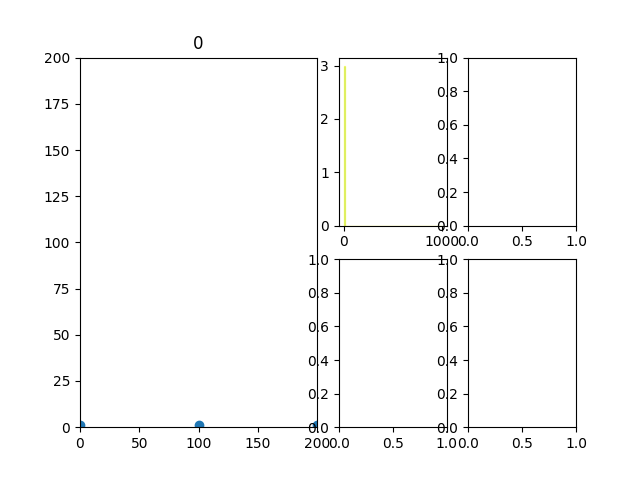

In [2]:
# TEST CELL FOR showAnimation
seed = 42
rng = default_rng(seed=seed) # instatiate the default random number generator
sqrtNumParts = 2

pPosGrid = list(itertools.product(np.linspace(20, 180,sqrtNumParts), np.linspace(20,180,sqrtNumParts)))
pVelGrid = list(rng.random(size=(sqrtNumParts**2,2))*1) #slightly randomize initial velocities

particles = [Disk(pPosGrid[i], pVelGrid[i]) for i in range(sqrtNumParts**2)][:-1]

e1 = Expt(particles, dt=0.1, tmax=5, animSpeed=0.5)

print(e1.avgKE)
e1.showAnimation1("seed = " + str(seed) + "     ")
print(e1.avgKE)

In [ ]:
plt.close("all")